In [80]:
import pandas as pd

file = 'merged_utrecht.csv'
merged_df = pd.read_csv(file)

## Datapreperation

In [103]:
print(len(merged_df))
filtered_df = merged_df.copy()

97281


In [105]:
filtered_df = filtered_df.dropna().reset_index(drop=True)
print(f'Number of houses after dropping missing_values: {len(filtered_df)}')

filtered = filtered_df[filtered_df["woz_2023"] < np.percentile(filtered_df["woz_2023"], 99.5)]

print(f'Number of houses after dropping high outliers in woz_2013: {len(filtered)}')

Number of houses after dropping missing_values: 79615
Number of houses after dropping high outliers in woz_2013: 79216


In [107]:
no_missing_values_df = filtered.dropna().reset_index(drop=True)

In [108]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np


def normalize_data(df):
    # Select only numerical columns
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Alternative: Standardization (mean=0, std=1)
    std_scaler = StandardScaler()
    df_standardized = std_scaler.fit_transform(df[num_cols])

    # Convert NumPy array back to DataFrame
    df_standardized = pd.DataFrame(df_standardized, columns=num_cols, index=df.index)

    return df_standardized

def convert_to_num(df):
    labelencoder = LabelEncoder()
    df['straat'] = labelencoder.fit_transform(df['straat'])
    df['buurt'] = labelencoder.fit_transform(df['buurt'])

    return df

def extract_numerical_postcode(postcode):
    # Keep only digits from the postcode
    numerical_values = ''.join(filter(str.isdigit, str(postcode)))
    return int(numerical_values) if numerical_values else None

def df_for_training(df):
    # Apply the function to extract numerical values from the postcode
    df['postcode'] = df['postcode'].apply(extract_numerical_postcode)

        # Ensure the column exists before applying the condition
    if 'grondoppervlakte' in df.columns:
        df['grondoppervlakte'] = np.where(df['grondoppervlakte'] > 0, 1, df['grondoppervlakte'])

    # Drop the 'huisnummer' column
    df = df.drop(columns=['huisnummer'], errors='ignore')  # Use errors='ignore' to avoid KeyError if the column doesn't exist

    # Encode categorical columns
    df = convert_to_num(df)
    

    #df = normalize_data(df)
    
    return df


df_train = df_for_training(no_missing_values_df)

print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79216 entries, 0 to 79215
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   postcode          79216 non-null  int64  
 1   straat            79216 non-null  int64  
 2   buurt             79216 non-null  int64  
 3   bouwjaar          79216 non-null  int64  
 4   grondoppervlakte  79216 non-null  float64
 5   oppervlakte       79216 non-null  int64  
 6   woz_2014          79216 non-null  float64
 7   woz_2015          79216 non-null  float64
 8   woz_2016          79216 non-null  float64
 9   woz_2017          79216 non-null  float64
 10  woz_2018          79216 non-null  float64
 11  woz_2019          79216 non-null  float64
 12  woz_2020          79216 non-null  float64
 13  woz_2021          79216 non-null  float64
 14  woz_2022          79216 non-null  float64
 15  woz_2023          79216 non-null  float64
 16  latitude          79216 non-null  float6

79615
423329.9629466809
79216
416259.9348616441


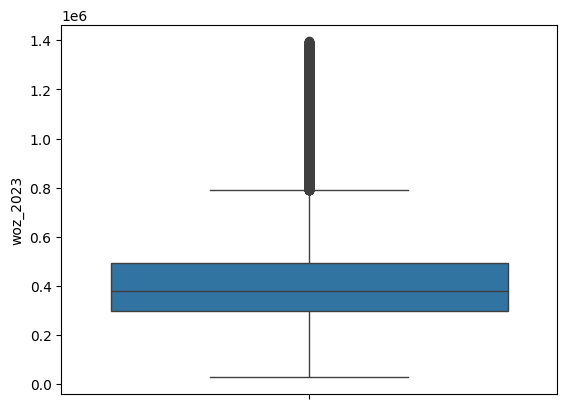

In [48]:
import numpy as np
import seaborn as sns
import pandas as pd

# Visualize the outliers
#sns.boxplot(df_train["woz_2023"])
print(len(df_train))
print(np.mean(df_train["woz_2023"]))

df_train = df_train[df_train["woz_2023"] < np.percentile(df_train["woz_2023"], 99.5)]


# Visualize again to confirm outliers have been removed
sns.boxplot(df_train["woz_2023"])
print(len(df_train))
print(np.mean(df_train["woz_2023"]))


In [109]:
from sklearn.model_selection import train_test_split

def split_data(df):
    
    y = df['woz_2023']
    X = df.drop(columns=['woz_2023'])
    

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
    # print("Training set shapes:", X_train.shape, y_train.shape)
    # print("Test set shapes:", X_test.shape, y_test.shape)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df_train)

Training set shapes: (63372, 17) (63372,)
Test set shapes: (15844, 17) (15844,)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from feature_engine.selection import RecursiveFeatureElimination

def RFE(df):
    # Define the model: XGBoost
     # Define the model (fewer trees for faster selection)
    regressor = RandomForestRegressor(n_jobs=-1, n_estimators=20, random_state=42)

    # Use RFECV for automatic feature selection with cross-validation
    rfe = RFECV(estimator=regressor, step=5, min_features_to_select=5, cv=3, n_jobs=-1)

    # Split the data
    X_train, X_test, y_train, y_test = split_data(df)

    # Fit the RFE model
    RFE_model.fit(X_train, y_train)

    # Get selected features
    selected_features = X_train.columns[RFE_model.get_support()]
    print("Selected Features:", list(selected_features))

    # Train a new model using only selected features
    model.fit(X_train[selected_features], y_train)

    # Get feature importances from the newly trained model
    feature_importances = pd.Series(model.feature_importances_, index=selected_features)
    
    # Plot feature importance
    feature_importances.plot.bar(figsize=(10, 5))
    plt.ylabel('Feature importance')
    plt.title('Feature Importance Derived from XGBoost')
    plt.show()

# Call the RFE function
RFE(df_train)


NameError: name 'df_train' is not defined

In [28]:
selected_features = ['postcode', 'straat', 'buurt', 'bouwjaar', 
                     'grondoppervlakte', 'oppervlakte', 'woz_2015', 
                     'woz_2016', 'woz_2019', 'woz_2021', 'woz_2022', 
                     'woz_2023', 'longitude']

# Select only the specified features
df_selected = df_train[selected_features]

X_train, X_test, y_train, y_test = split_data(df_selected)


Training set shapes: (63372, 12) (63372,)
Test set shapes: (15844, 12) (15844,)


#### Outliers

### Evaluate Methods

In [50]:
def evaluate_model(y_test, y_pred):
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print results
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2):", r2)
    
    # Display predictions alongside actual values
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
    print("\nPredictions vs Actual:")
    print(results)

    return results, mse, r2

## Predict

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [51]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


def XGB(X_train, X_test, y_train):

    # Train an XGBoost Regressor
    model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)

    return y_pred


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Get values
#y_pred = XGB(X_train_scaled, X_test_scaled, y_train)
y_pred = XGB(X_train, X_test, y_train)

In [52]:
result_XGB, mse_XGB, r2_XGB = evaluate_model(y_test, y_pred)

Mean Squared Error (MSE): 487640162.8493703
R-squared (R2): 0.9832238652531959

Predictions vs Actual:
          Actual     Predicted
0       221000.0  2.268024e+05
1       411000.0  4.116614e+05
2       611000.0  5.837324e+05
3       409000.0  3.546946e+05
4       614000.0  6.048882e+05
...          ...           ...
15839   369000.0  3.685046e+05
15840   283000.0  2.772077e+05
15841   413000.0  4.145895e+05
15842  1229000.0  1.311152e+06
15843   369000.0  3.693793e+05

[15844 rows x 2 columns]


In [34]:
import numpy as np

rmse = np.sqrt(mse_XGB)
print("Root Mean Squared Error (RMSE):", rmse)



Root Mean Squared Error (RMSE): 22082.576001213496


#### RF

In [35]:
from sklearn.ensemble import RandomForestRegressor

def random_forest(X_train, X_test, y_train):
    
    rf = RandomForestRegressor(
        n_estimators=100,  # Number of trees in the forest
        max_depth=10,  # Maximum depth of each tree (can be tuned)
        random_state=42,  # For reproducibility
        n_jobs=-1  # Use all available CPU cores for parallel computation
    )

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    return y_pred

#y_pred_rf = random_forest(X_train_scaled, X_test_scaled, y_train)
y_pred_rf = random_forest(X_train, X_test, y_train)

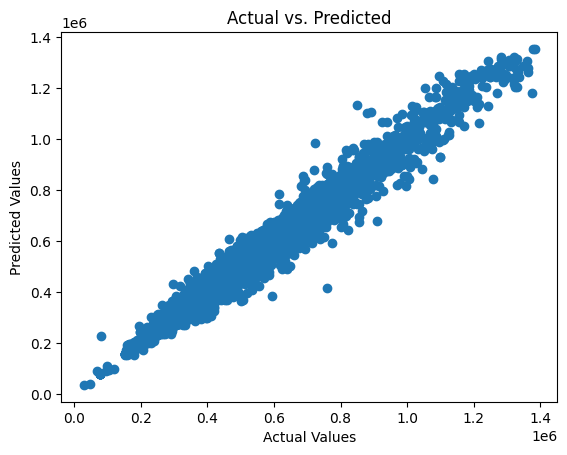

In [30]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred_rf)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.show()

In [36]:
result_rf, mse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)

rmse = np.sqrt(mse_rf)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Squared Error (MSE): 626132274.4051048
R-squared (R2): 0.9784593636763516

Predictions vs Actual:
          Actual     Predicted
0       221000.0  2.299875e+05
1       411000.0  4.100054e+05
2       611000.0  5.929827e+05
3       409000.0  3.488367e+05
4       614000.0  5.964759e+05
...          ...           ...
15839   369000.0  3.617456e+05
15840   283000.0  2.801287e+05
15841   413000.0  4.176226e+05
15842  1229000.0  1.261247e+06
15843   369000.0  3.730876e+05

[15844 rows x 2 columns]
Root Mean Squared Error (RMSE): 25022.635241019376


#### Linear regression

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

def linregression(X_train, X_test, y_train):
    




    # Create a linear regression model
    model = LinearRegression()

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    return y_pred

y_pred_lin = linregression(X_train, X_test, y_train)

#y_pred_lin = linregression(X_train_scaled, X_test_scaled, y_train)
result_lin, mse_lin, r2_lin = evaluate_model(y_test, y_pred_lin)




# # Optional: Display coefficients
# coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
# print("\nCoefficients:\n", coefficients)

Mean Squared Error (MSE): 878864755.7413099
R-squared (R2): 0.9697646857461828

Predictions vs Actual:
          Actual     Predicted
0       221000.0  2.363087e+05
1       411000.0  4.148939e+05
2       611000.0  6.055299e+05
3       409000.0  3.661501e+05
4       614000.0  6.012655e+05
...          ...           ...
15839   369000.0  3.498054e+05
15840   283000.0  2.689058e+05
15841   413000.0  4.202970e+05
15842  1229000.0  1.349834e+06
15843   369000.0  3.767208e+05

[15844 rows x 2 columns]


XGB
With selection:
Mean Squared Error (MSE): 8371095964.999092
R-squared (R2): 0.7909573041958049

Without
Mean Squared Error (MSE): 10571938665.917017
R-squared (R2): 0.735997942462945

RF
With
Mean Squared Error (MSE): 853763302.0243374
R-squared (R2): 0.9786798547071873

Without - scaled
Mean Squared Error (MSE): 834290702.8893248
R-squared (R2): 0.9791661237255473

Without - not scaled
Mean Squared Error (MSE): 835570511.1680093
R-squared (R2): 0.9791341644010088


Lin
With
Mean Squared Error (MSE): 1089527538.7598574
R-squared (R2): 0.972792358992471

Without
Mean Squared Error (MSE): 1081608297.339182
R-squared (R2): 0.9729901179934697

## Make predicted Utrecht map-ready

In [59]:
def initialize_csv(file_path: str):
    # Define the columns as per the specified labels
    columns = [
        "postcode", "huisnummer", "straat", "buurt", "bouwjaar", "grondoppervlakte", "oppervlakte",
        "woz_2014", "woz_2015", "woz_2016", "woz_2017", "woz_2018", "woz_2019", "woz_2020", 
        "woz_2021", "woz_2022", "woz_2023", "woz_2024*", "woz_2025*", "woz_2026*",
        "act_woz_incr", "pred_change_24", "pred_change_25", "pred_change_26",
        "woz/m2_23", "woz/m2_24", "woz/m2_25", "woz/m2_24",
        "latitude", "longitude"rdat er voorspellingen van op de verscheidene datasets gedaan kunnen worden,
moeten de categorische variabelen worden laten vallen, of worden veranderd naar
numerieke variabelen.
Daarna worden er een tweede dataset gemaakt van de orginele, door een RFE
toe te passen, met de tweede dataset alleen "belangrijke variabalen" heeft. Beide
datasets zijn gesplits in training en test. Leg uit hoe dit werkt.
Daarna hoe voorspel ik volgende jaar op basis van model getraind op bepaalde
    ]

    # Create an empty DataFrame with these columns
    df = pd.DataFrame(columns=columns)

    # Save to CSV
    df.to_csv(file_path, index=False)
    print(f"Initialized CSV at: {file_path}")

file_path = 'utrecht_map.csv'
initialize_csv(file_path)

Initialized CSV at: utrecht_map.csv


In [110]:
def train_model(X, y):
    # model = RandomForestRegressor(
    #         n_estimators=100,
    #         max_depth=10,
    #         random_state=42,
    #         n_jobs=-1
    #     )
    model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=42)

    return model.fit(X, y)


In [111]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

def predict_woz_24(df):
    df_adj = df.copy()
    

    #model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=42)
    

    # Include all past features + previous predictions
    feature_cols = [col for col in df.columns if col != "woz_2023"]
    
    X = df[feature_cols]
    y = df["woz_2023"]  

    model = train_model(X, y)
    
    # Rename the columns
    df_adj.rename(columns={
        'woz_2014': 'woz_2013', 
        'woz_2015': 'woz_2014', 
        'woz_2016': 'woz_2015', 
        'woz_2017': 'woz_2016', 
        'woz_2018': 'woz_2017', 
        'woz_2019': 'woz_2018', 
        'woz_2020': 'woz_2019', 
        'woz_2021': 'woz_2020', 
        'woz_2022': 'woz_2021',
        'woz_2023': 'woz_2022',
        }, inplace=True)

    
    X = df_adj[feature_cols]

    # Make predictions on the validation data, for 23
    prediction = model.predict(X)
    prediction = prediction.round().astype(int)  # Round to nearest integer

    column_name = "woz_2024"
    latitude_index = df.columns.get_loc("latitude")  # Get the index of 'latitude'
    df.insert(latitude_index, column_name, prediction)  # Insert the new column

    return df, model, feature_cols

# Apply function

df_train = df_for_training(no_mv)
df_train = df_train[df_train["woz_2023"] < np.percentile(df_train["woz_2023"], 99.5)]

df_24, model, feature_cols = predict_woz_24(df_train)
df_24.head()


,postcode,straat,buurt,bouwjaar,grondoppervlakte,oppervlakte,woz_2014,woz_2015,woz_2016,woz_2017,woz_2018,woz_2019,woz_2020,woz_2021,woz_2022,woz_2023,woz_2024,latitude,longitude
0,3551,8,0,1913,1.0,60,138000.0,138000.0,151000.0,205000.0,234000.0,257000.0,218000.0,287000.0,344000.0,404000.0,396705,52.101190,5.100600
1,3551,8,0,1913,0.0,117,187000.0,188000.0,215000.0,263000.0,339000.0,381000.0,412000.0,445000.0,401000.0,363000.0,386836,52.101180,5.100586
2,3551,8,0,1913,0.0,54,134000.0,134000.0,124000.0,153000.0,194000.0,216000.0,233000.0,267000.0,319000.0,310000.0,306086,52.100977,5.100716
3,3551,8,0,1913,0.0,80,161000.0,162000.0,175000.0,200000.0,215000.0,239000.0,284000.0,296000.0,358000.0,358000.0,367393,52.100968,5.100702
4,3551,8,0,1913,0.0,60,156000.0,157000.0,169000.0,220000.0,222000.0,245000.0,209000.0,277000.0,316000.0,318000.0,335759,52.101239,5.100676


In [112]:
print(np.mean(df_24["woz_2023"]), np.mean(df_24["woz_2024"]))

416259.9348616441 423989.2580917996


In [113]:
def predict_woz_25(df, model, feature_cols):
    df_adj = df.copy()
    

    # Rename the columns
    df_adj.rename(columns={
        'woz_2014': 'woz_2012', 
        'woz_2015': 'woz_2013', 
        'woz_2016': 'woz_2014', 
        'woz_2017': 'woz_2015', 
        'woz_2018': 'woz_2016', 
        'woz_2019': 'woz_2017', 
        'woz_2020': 'woz_2018', 
        'woz_2021': 'woz_2019', 
        'woz_2022': 'woz_2020',
        'woz_2023': 'woz_2021',
        'woz_2024': 'woz_2022',
        }, inplace=True)

    
    X = df_adj[feature_cols]

    # Make predictions on the validation data, for 23
    prediction = model.predict(X)
    prediction = prediction.round().astype(int)  # Round to nearest integer

    column_name = "woz_2025"
    latitude_index = df.columns.get_loc("latitude")  # Get the index of 'latitude'
    df.insert(latitude_index, column_name, prediction)  # Insert the new column

    return df

# Apply function

df_25 = predict_woz_25(df_24, model, feature_cols)
df_25.head()

,postcode,straat,buurt,bouwjaar,grondoppervlakte,oppervlakte,woz_2014,woz_2015,woz_2016,woz_2017,woz_2018,woz_2019,woz_2020,woz_2021,woz_2022,woz_2023,woz_2024,woz_2025,latitude,longitude
0,3551,8,0,1913,1.0,60,138000.0,138000.0,151000.0,205000.0,234000.0,257000.0,218000.0,287000.0,344000.0,404000.0,396705,407367,52.101190,5.100600
1,3551,8,0,1913,0.0,117,187000.0,188000.0,215000.0,263000.0,339000.0,381000.0,412000.0,445000.0,401000.0,363000.0,386836,403323,52.101180,5.100586
2,3551,8,0,1913,0.0,54,134000.0,134000.0,124000.0,153000.0,194000.0,216000.0,233000.0,267000.0,319000.0,310000.0,306086,306330,52.100977,5.100716
3,3551,8,0,1913,0.0,80,161000.0,162000.0,175000.0,200000.0,215000.0,239000.0,284000.0,296000.0,358000.0,358000.0,367393,377647,52.100968,5.100702
4,3551,8,0,1913,0.0,60,156000.0,157000.0,169000.0,220000.0,222000.0,245000.0,209000.0,277000.0,316000.0,318000.0,335759,356466,52.101239,5.100676


In [114]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

def predict_woz_26(df, model, feature_cols):
    df_adj = df.copy()
    


    df_adj.rename(columns={
        'woz_2014': 'woz_2011', 
        'woz_2015': 'woz_2012', 
        'woz_2016': 'woz_2013', 
        'woz_2017': 'woz_2014', 
        'woz_2018': 'woz_2015', 
        'woz_2019': 'woz_2016', 
        'woz_2020': 'woz_2017', 
        'woz_2021': 'woz_2018', 
        'woz_2022': 'woz_2019',
        'woz_2023': 'woz_2020',
        'woz_2024': 'woz_2021',
        'woz_2025': 'woz_2022',
        }, inplace=True)

    X = df_adj[feature_cols]

    # Make predictions on the validation data, for 26
    prediction = model.predict(X)
    prediction = prediction.round().astype(int)  # Round to nearest integer

    column_name = "woz_2026"
    latitude_index = df.columns.get_loc("latitude")  # Get the index of 'latitude'
    df.insert(latitude_index, column_name, prediction)  # Insert the new column

    return df

# Apply function


df_26 = predict_woz_26(df_25, model, feature_cols)

df_26.head()

,postcode,straat,buurt,bouwjaar,grondoppervlakte,oppervlakte,woz_2014,woz_2015,woz_2016,woz_2017,...,woz_2019,woz_2020,woz_2021,woz_2022,woz_2023,woz_2024,woz_2025,woz_2026,latitude,longitude
0,3551,8,0,1913,1.0,60,138000.0,138000.0,151000.0,205000.0,...,257000.0,218000.0,287000.0,344000.0,404000.0,396705,407367,407972,52.101190,5.100600
1,3551,8,0,1913,0.0,117,187000.0,188000.0,215000.0,263000.0,...,381000.0,412000.0,445000.0,401000.0,363000.0,386836,403323,431166,52.101180,5.100586
2,3551,8,0,1913,0.0,54,134000.0,134000.0,124000.0,153000.0,...,216000.0,233000.0,267000.0,319000.0,310000.0,306086,306330,321393,52.100977,5.100716
3,3551,8,0,1913,0.0,80,161000.0,162000.0,175000.0,200000.0,...,239000.0,284000.0,296000.0,358000.0,358000.0,367393,377647,383953,52.100968,5.100702
4,3551,8,0,1913,0.0,60,156000.0,157000.0,169000.0,220000.0,...,245000.0,209000.0,277000.0,316000.0,318000.0,335759,356466,352092,52.101239,5.100676


## Calculate features for map.

In [115]:

def finalized_df_map(df):
    # Calculate percentage increases
    df["act_woz_incr"] = (((df["woz_2023"] - df["woz_2014"]) / df["woz_2014"]) * 100).round(2)
    df["pred_change_24"] = (((df["woz_2024"] - df["woz_2023"]) / df["woz_2023"]) * 100).round(2)
    df["pred_change_25"] = (((df["woz_2025"] - df["woz_2023"]) / df["woz_2023"]) * 100).round(2)
    df["pred_change_26"] = (((df["woz_2026"] - df["woz_2023"]) / df["woz_2023"]) * 100).round(2)

    # Calculate woz/m2 ratios
    df["woz/m2_23"] = (df["woz_2023"] / df["oppervlakte"]).round(2)
    df["woz/m2_24"] = (df["woz_2024"] / df["oppervlakte"]).round(2)
    df["woz/m2_25"] = (df["woz_2025"] / df["oppervlakte"]).round(2)
    df["woz/m2_26"] = (df["woz_2026"] / df["oppervlakte"]).round(2)

    return df

ad_26_df = df_26.copy()
final_df = finalized_df_map(ad_26_df)

In [116]:
final_df.head()


,postcode,straat,buurt,bouwjaar,grondoppervlakte,oppervlakte,woz_2014,woz_2015,woz_2016,woz_2017,...,latitude,longitude,act_woz_incr,pred_change_24,pred_change_25,pred_change_26,woz/m2_23,woz/m2_24,woz/m2_25,woz/m2_26
0,3551,8,0,1913,1.0,60,138000.0,138000.0,151000.0,205000.0,...,52.101190,5.100600,192.75,-1.81,0.83,0.98,6733.33,6611.75,6789.45,6799.53
1,3551,8,0,1913,0.0,117,187000.0,188000.0,215000.0,263000.0,...,52.101180,5.100586,94.12,6.57,11.11,18.78,3102.56,3306.29,3447.21,3685.18
2,3551,8,0,1913,0.0,54,134000.0,134000.0,124000.0,153000.0,...,52.100977,5.100716,131.34,-1.26,-1.18,3.68,5740.74,5668.26,5672.78,5951.72
3,3551,8,0,1913,0.0,80,161000.0,162000.0,175000.0,200000.0,...,52.100968,5.100702,122.36,2.62,5.49,7.25,4475.00,4592.41,4720.59,4799.41
4,3551,8,0,1913,0.0,60,156000.0,157000.0,169000.0,220000.0,...,52.101239,5.100676,103.85,5.58,12.10,10.72,5300.00,5595.98,5941.10,5868.20


In [117]:
print(np.mean(final_df["woz_2023"]), np.mean(final_df["woz_2024"]), np.mean(final_df["woz_2025"]), np.mean(final_df["woz_2026"]))

416259.9348616441 423989.2580917996 438036.01517370227 456040.4027974147


XGB
418232.57916073187 425503.04729100474 438620.7259641722 454137.23970088747

RF
418232.57916073187 424311.70012052153 438809.2725566999 457246.7419469705


In [118]:
final_map = no_missing_values_df.copy()


In [119]:
# Check if the columns exist in final_df
columns_to_add_1 = ['woz_2026', 'woz_2025', 'woz_2024']
# Define the columns to add
columns_to_add_2 = ['act_woz_incr', 'pred_change_24', 'pred_change_25', 'pred_change_26', 
                  'woz/m2_23', 'woz/m2_24', 'woz/m2_25', 'woz/m2_26']


# Ensure all columns exist in final_df
if all(col in final_df.columns for col in columns_to_add_1):
    # Create a new DataFrame with the columns to add
    new_columns_df = final_df[columns_to_add_1]

    # Insert the new columns into final_map before the latitude column
    latitude_index = final_map.columns.get_loc('latitude')  # Get the index of the latitude column

    # Insert each column at the correct position
    for col in columns_to_add_1:
        final_map.insert(latitude_index, col, new_columns_df[col])

    for col in columns_to_add_2:
        final_map[col] = final_df[col]



# If you want to check the result


In [120]:
print(len(final_map))

79216


In [121]:
final_map.head()

,postcode,huisnummer,straat,buurt,bouwjaar,grondoppervlakte,oppervlakte,woz_2014,woz_2015,woz_2016,...,latitude,longitude,act_woz_incr,pred_change_24,pred_change_25,pred_change_26,woz/m2_23,woz/m2_24,woz/m2_25,woz/m2_26
0,3551,10,Acaciastraat,2e Daalsebuurt en omgeving,1913,1.0,60,138000.0,138000.0,151000.0,...,52.101190,5.100600,192.75,-1.81,0.83,0.98,6733.33,6611.75,6789.45,6799.53
1,3551,10-BS,Acaciastraat,2e Daalsebuurt en omgeving,1913,0.0,117,187000.0,188000.0,215000.0,...,52.101180,5.100586,94.12,6.57,11.11,18.78,3102.56,3306.29,3447.21,3685.18
2,3551,11,Acaciastraat,2e Daalsebuurt en omgeving,1913,0.0,54,134000.0,134000.0,124000.0,...,52.100977,5.100716,131.34,-1.26,-1.18,3.68,5740.74,5668.26,5672.78,5951.72
3,3551,11-BS,Acaciastraat,2e Daalsebuurt en omgeving,1913,0.0,80,161000.0,162000.0,175000.0,...,52.100968,5.100702,122.36,2.62,5.49,7.25,4475.00,4592.41,4720.59,4799.41
4,3551,12,Acaciastraat,2e Daalsebuurt en omgeving,1913,0.0,60,156000.0,157000.0,169000.0,...,52.101239,5.100676,103.85,5.58,12.10,10.72,5300.00,5595.98,5941.10,5868.20


In [122]:
final_map.to_csv('utrecht_map.csv', index=False)